In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from multiprocessing import Pool
from scipy import stats
import math

# Blue: Model Based
# Green: Model Free

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

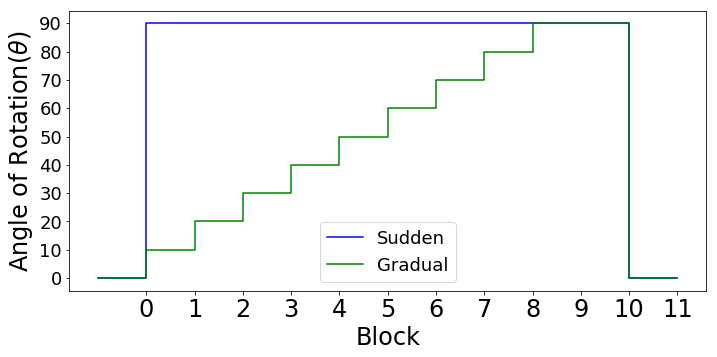

In [35]:
#Plot Angles across blocks for poster
x = np.array(range(-1, 12))
y = np.array([0, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 90, 0])
y_sudden = np.array([0, 0, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 0])
plot_sudden = plt.step(x, y_sudden, color = 'blue')
plot_gradual = plt.step(x, y, color = 'Green')
plt.legend(['Sudden', 'Gradual'])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90], ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90'])
plt.xlabel('Block')
plt.ylabel('Angle of Rotation' + r'$(\theta)$')
plt.rcParams[('figure.figsize')] = [10, 5]
plt.tight_layout()
plt.savefig('rotation_angles.jpg', dpi = 300)

In [2]:
def times(data, block):
    initial_time = scipy.io.loadmat('data/data{data}/initial_time/initial_time{block}.mat'.format(block=str(block), data=str(data)))
    movement_time = scipy.io.loadmat('data/data{data}/movement_time/movement_time{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    initial_time = initial_time['initial_time'][:, 0]
    movement_time = movement_time['movement_time'][:, 0]
    return initial_time, movement_time


In [3]:
def get_times():
    initial_times = np.zeros((60, 12, 64))
    movement_times = np.zeros((60, 12, 64))
    for participant in range(60):
        for block in range(12):
            it, mt = times(participant+1000, block)
            initial_times[participant, block] = it
            movement_times[participant, block] = mt
    return initial_times, movement_times

In [4]:
its, mts = get_times()

In [5]:
def wald_density(rt, a, v):
    dc = 0.1
    mu = a/v
    lamb = a**2/dc**2
    return np.sqrt(lamb/(2*np.pi*rt**3)) * np.exp((-lamb*(rt-mu)**2)/(2*mu**2*rt))

In [6]:
def wald_cumm_density(rt, a, v):
    return scipy.integrate.quad(wald_density, 0, rt, args = (a, v))[0]
    

In [ ]:
total_times = its
def get_average_quantile(total_times):
    quantiles = np.zeros((len(total_times), 12, 5))
    for participant in range(1, len(total_times)):
        if participant == 7:
            continue
        else:
            for block in range(12):
                quantiles[participant, block, :] =  np.quantile(total_times[participant, block], np.array([0.1, 0.3, 0.5, 0.7, 0.9]))
    return np.mean(quantiles, axis=0)


In [ ]:
average_quantiles = get_average_quantile(its)

In [ ]:
its[its > 0.000001]

1. Find Quantiles for the data. 
2. For each quantile point, calculate predicted/expected frequencies for a wald with some parameters

    - Find a quantile point in the data.

    - Find wald area between that quantile point and the previous quantile point. This wald area is for a wald with some parameters.

    - Find expected frequencies by multiplying the normalized areas with total observations.
    
3. Observed Frequencies are the ideal frequencies.

4. Gsquared is 2 * Sum(observed * log(observed/expected))

In [7]:
def get_wald_areas(par, data):
    a, v, ter = par[0], par[1], par[2]
    data = data - ter
    quantiles = np.quantile(data, [0.1, 0.3, 0.5, 0.7, 0.9])
    cuts = np.append(np.insert(quantiles, 0, 0.000001), np.inf)
    areas = list()
    for i in range(len(cuts) - 1):
        areas.append(wald_cumm_density(cuts[i+1], a, v) - wald_cumm_density(cuts[i], a, v))
    return np.array(areas)

In [8]:
def get_exp_freq(areas, data):
    #count = areas/(float)(np.sum(areas))
    #count = count*len(data)
    #print(areas)
    #print(len(data))
    return areas*len(data)

In [ ]:
def get_wald_areas(par, quantiles):
    a, v, ter = par[0], par[1], par[2]
    #data = data - ter
#    quantiles = np.quantile(data, [0.1, 0.3, 0.5, 0.7, 0.9])
#    quantiles = average_quantiles[block]
    quantiles = quantiles - ter
    cuts = np.append(np.insert(quantiles, 0, 0.000001), np.inf)
    areas = list()
    for i in range(len(cuts) - 1):
        areas.append(wald_cumm_density(cuts[i+1], a, v) - wald_cumm_density(cuts[i], a, v))
    return np.array(areas)

In [9]:
def get_gsq(par, data, observed_freq):
    #print (data)
    #Fix Boundary rate
    #par[0] = 0.1
    #Fixed Drift Rate
    #par[1] = 0.1
    #fixed ter
    par[2] = min(data) - 0.00004
    expected_freq = get_exp_freq(get_wald_areas(par, data), data)
    penalty = 0
#    if par[0] != 0.1:
#        penalty = penalty + 10
    if par[1] <= 0:
        penalty = penalty + 10
    if par[2] <= 0:
        penalty = penalty + 10
    #print (expected_freq)
    gsq = penalty + 2 * np.sum(observed_freq*np.log(observed_freq/expected_freq))
    
    return gsq

In [23]:
def get_gsq(par, observed_freq, quantiles):
    expected_freq = get_exp_freq(get_wald_areas(par, quantiles))
    penalty = 0
    if par[0] < 0:
        penalty = penalty + 10
    if par[1] < 0:
        penaelty = penalty + 10
    if par[2] < 0:
        penalty = penalty + 10
   
    gsq = penalty + 2 * np.sum(observed_freq*np.log(observed_freq/expected_freq))
    return gsq

In [ ]:
def plot_rt_dist(rt, condition, block):
    total_time = np.ravel(np.concatenate((rt[condition+1:7:4, block], rt[condition+8::4, block])))
    plt.hist(total_time[total_time>0.0004], bins = 100)

Fit Loop. Scipy optim

# Fit all participants

In [32]:
def fit_all(par, times):
    fit_a = np.zeros((4, 12))
    fit_v = np.zeros((4, 12))
    fit_gsq = np.zeros((4, 12))
    fit_ter = np.zeros((4, 12))
    optim_fail = np.zeros((4, 12))
    initial_params = par
    for condition in range(4):
        average_quantiles = get_average_quantile(np.concatenate((times[condition+1:7:4], times[condition+8::4])))

        for block in range(12):
            
            total_times = np.ravel(np.concatenate((times[condition+1:7:4, block], times[condition+8::4, block])))
            #total_times = total_times[total_times < 5]
            total_times = total_times[total_times > 0.0004]
            #print (len(total_times))
            observed_freq = np.array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1]) * 64
            optimal = scipy.optimize.minimize(get_gsq, x0 = initial_params, args = (observed_freq, average_quantiles[block]), method='SLSQP')
            
            fit_a[condition,block] = optimal.x[0]
            fit_v[condition, block] = optimal.x[1]
            fit_ter[condition, block] = optimal.x[2]
            fit_gsq[condition, block] = optimal.fun
            #print (block)
        print (condition)
            
    return fit_a, fit_v, fit_ter, fit_gsq, optim_fail

In [ ]:
def plot_all(fit_a, fit_v, fit_ter, fit_gsq, optim_fail):
    plot_a1, = plt.plot(fit_a[0], 'r')
    plot_a2, = plt.plot(fit_a[1], 'b')
    plot_a3, = plt.plot(fit_a[2], 'g')
    plot_a4, = plt.plot(fit_a[3], 'y')
    plt.title('Fit Boundary Parameters')
    plt.xlabel('Block')
    plt.ylabel('Parameter Values')
    plt.legend((plot_a1, plot_a2, plot_a3, plot_a4), ("Sudden Accuracy", "Gradual Speed", "Gradual Accuracy", "Sudden Speed"))
    plt.show()
    
    plot_v1, = plt.plot(fit_v[0], 'r')
    plot_v2, = plt.plot(fit_v[1], 'b')
    plot_v3, = plt.plot(fit_v[2], 'g')
    plot_v4, = plt.plot(fit_v[3], 'y')
    plt.title('Fit Drift Parameters')
    plt.xlabel('Block')
    plt.ylabel('Parameter Value')
    plt.legend((plot_v1, plot_v2, plot_v3, plot_v4), ("Sudden Accuracy", "Gradual Speed", "Gradual Accuracy", "Sudden Speed"))
    plt.show()
    
    plot_t1, = plt.plot(fit_ter[0], 'r')
    plot_t2, = plt.plot(fit_ter[1], 'b')
    plot_t3, = plt.plot(fit_ter[2], 'g')
    plot_t4, = plt.plot(fit_ter[3], 'y')
    plt.title('Fit non decision time Parameters')
    plt.xlabel('Block')
    plt.ylabel('Parameter Value')
    plt.legend((plot_t1, plot_t2, plot_t3, plot_t4), ("Sudden Accuracy", "Gradual Speed", "Gradual Accuracy", "Sudden Speed"))
    plt.show()
    
    plot_g1, = plt.plot(fit_gsq[0], 'r')
    plot_g2, = plt.plot(fit_gsq[1], 'b')
    plot_g3, = plt.plot(fit_gsq[2], 'g')
    plot_g4, = plt.plot(fit_gsq[3], 'y')
    plt.title('Fit GSQs')
    plt.xlabel('Block')
    plt.ylabel('Parameter Value')
    plt.legend((plot_g1, plot_g2, plot_g3, plot_g4), ("Sudden Accuracy", "Gradual Speed", "Gradual Accuracy", "Sudden Speed"))
    plt.show()

In [ ]:
#plot_all(a, v, ter, gsq, optim_fail)

In [ ]:
#observed_freq = 

In [10]:
def run_fits(initial_params, times):
    #initialize fit variables
    fit_a = np.zeros((60, 12))
    fit_v = np.zeros((60, 12))
    fit_gsq = np.zeros((60, 12))
    fit_ter = np.zeros((60, 12))
    optim_fail = np.zeros((60, 12))
    #optimals = list()
    gsqs = np.zeros((3))
    for participant in range(60):
        for block in range(12):
            #preprocess observed frequencies here first
            total_times = times[participant, block]
            total_times = total_times[total_times < 8]
            total_times = total_times[total_times > 0.0004]
            #initial_params = np.array([[0.1, 0.1, np.min(total_times) - 0.001], [0.9, 0.9, np.min(total_times) - 0.001], [0.4, 0.4, np.min(total_times) - 0.001]])
            #initial_params = [0.5, 0.5, np.min(total_times) - 0.00001]
            #for i in range(len(initial_params)):
            observed_freq = np.array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1])*len(total_times)
            optimal = scipy.optimize.minimize(get_gsq, x0 = initial_params, args = (total_times, observed_freq), method='Nelder-Mead')
            #    optimals.append(optimal)
            #    gsqs[i] = optimal.fun
            #optimal = optimals[np.argmin(gsqs)]
            if optimal.success == False:
                optim_fail[participant, block] = 1

            fit_a[participant, block] = optimal.x[0]
            fit_v[participant, block] = optimal.x[1]
            fit_ter[participant, block] = optimal.x[2]
            fit_gsq[participant, block] = optimal.fun
        print (participant)
    return fit_a, fit_v, fit_ter, fit_gsq, optim_fail
        

In [10]:
fit_a, fit_v, fit_ter, fit_gsq, optim_fail = run_fits([0.1, 0.1, 0], its)

NameError: name 'its' is not defined

In [11]:
def plot_all(fit_a, fit_v, fit_ter, fit_gsq, optim_fail):
    plot_a1, = plt.plot(np.mean(fit_a[1::4], axis=0), 'r')
    plot_a2, = plt.plot(np.mean(fit_a[2::4], axis=0), 'b')
    plot_a3, = plt.plot(np.mean(fit_a[3::4], axis=0), 'g')
    plot_a4, = plt.plot(np.mean(fit_a[4::4], axis=0), 'y')
    plt.title('Fit Boundary Parameters')
    plt.xlabel('Block')
    plt.ylabel('Parameter Values')
    plt.legend((plot_a1, plot_a2, plot_a3, plot_a4), ("Sudden Accuracy", "Gradual Speed", "Gradual Accuracy", "Sudden Speed"))
    plt.show()
    
    plot_v1, = plt.plot(np.mean(fit_v[1::4], axis=0), 'r')
    plot_v2, = plt.plot(np.mean(fit_v[2::4], axis=0), 'b')
    plot_v3, = plt.plot(np.mean(fit_v[3::4], axis=0), 'g')
    plot_v4, = plt.plot(np.mean(fit_v[4::4], axis=0), 'y')
    plt.title('Fit Drift Parameters')
    plt.xlabel('Block')
    plt.ylabel('Parameter Value')
    plt.legend((plot_v1, plot_v2, plot_v3, plot_v4), ("Sudden Accuracy", "Gradual Speed", "Gradual Accuracy", "Sudden Speed"))
    plt.show()
    
    plot_t1, = plt.plot(np.mean(fit_ter[1::4], axis=0), 'r')
    plot_t2, = plt.plot(np.mean(fit_ter[2::4], axis=0), 'b')
    plot_t3, = plt.plot(np.mean(fit_ter[3::4], axis=0), 'g')
    plot_t4, = plt.plot(np.mean(fit_ter[4::4], axis=0), 'y')
    plt.title('Fit non decision time Parameters')
    plt.xlabel('Block')
    plt.ylabel('Parameter Value')
    plt.legend((plot_t1, plot_t2, plot_t3, plot_t4), ("Sudden Accuracy", "Gradual Speed", "Gradual Accuracy", "Sudden Speed"))
    plt.show()
    
    plot_g1, = plt.plot(np.median(fit_gsq[1::4], axis=0), 'r')
    plot_g2, = plt.plot(np.median(fit_gsq[2::4], axis=0), 'b')
    plot_g3, = plt.plot(np.median(fit_gsq[3::4], axis=0), 'g')
    plot_g4, = plt.plot(np.median(fit_gsq[4::4], axis=0), 'y')
    plt.title('Fit GSQs')
    plt.xlabel('Block')
    plt.ylabel('Parameter Value')
    plt.legend((plot_g1, plot_g2, plot_g3, plot_g4), ("Sudden Accuracy", "Gradual Speed", "Gradual Accuracy", "Sudden Speed"))
    plt.show()

In [ ]:
#plot_all(a, fit_v, fit_ter, fit_gsq, optim_fail)

# Just Log Likelihoods

In [ ]:
def wald_density_threeparam(rt, a, v, ter):
    dc = 0.1
    mu = a/v
    lamb = a**2/dc**2
    rt = rt - ter
    return np.sqrt(lamb/(2*np.pi*rt**3)) * np.exp((-lamb*(rt-mu)**2)/(2*mu**2*rt))

In [ ]:
def get_loglikelihood(par, x):
    a = par[0]
    v = par[1]
    ter = par[2]
    log_likelihood = 0
    penalty = 10
    for i in range(len(x)):
        #print (x)
        log_likelihood = log_likelihood - np.log(wald_density_threeparam(x[i], a, v, ter))
    if a < 0:
        log_likelihood = log_likelihood - penalty
    if v < 0:
        log_likelihood = log_likelihood - penalty
    if ter < 0:
        log_likelihood = log_likelihood - penalty

    return log_likelihood

In [ ]:
def run_fits_lls(initial_params, times):
    #initialize fit variables
    fit_a = np.zeros((59, 12))
    fit_v = np.zeros((59, 12))
    fit_gsq = np.zeros((59, 12))
    fit_ter = np.zeros((59, 12))
    optim_fail = np.zeros((59, 12))
    #optimals = list()
    gsqs = np.zeros((3))
    for participant in range(1, 59):
        if participant == 7 or participant == 30:
            continue
        for block in range(12):
            #preprocess observed frequencies here first
            total_times = times[participant, block]
            #initial_params = np.array([[0.1, 0.1, np.min(total_times) - 0.001], [0.9, 0.9, np.min(total_times) - 0.001], [0.4, 0.4, np.min(total_times) - 0.001]])
            #initial_params = [0.5, 0.5, np.min(total_times) - 0.00001]
            #for i in range(len(initial_params)):
            observed_freq = np.array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1])*len(total_times)
            optimal = scipy.optimize.minimize(get_loglikelihood, x0 = initial_params, args = (total_times[total_times > 0.001]), method='Nelder-Mead')
            #    optimals.append(optimal)
            #    gsqs[i] = optimal.fun
            #optimal = optimals[np.argmin(gsqs)]
            if optimal.success == False:
                optim_fail[participant, block] = 1

            fit_a[participant, block] = optimal.x[0]
            fit_v[participant, block] = optimal.x[1]
            fit_ter[participant, block] = optimal.x[2]
            fit_gsq[participant, block] = optimal.fun
        print (participant)
    return fit_a, fit_v, fit_ter, fit_gsq, optim_fail
        

In [ ]:
#fit_a, fit_v, fit_ter, fit_gsq, optim_fail = run_fits_lls([0.1, 0.1, 0], its)

In [ ]:
#plot_all(fit_a, fit_v, fit_ter, fit_gsq, optim_fail)

# Modifying initial times
1. Get a trajectory
2. Define a distance from the start point for initial time, call it dist_from_start.
3. Get movement time for that trajectory.
4. Sampling rate = Movement time/number of samples in the trajectory
5. Find the number of samples till dist_from_start, call it num_initiating_samples.
6. time_to_initiate = Sampling Rate * num_initiating_samples.
7. total_time = its + time_to_initiate

In [12]:
def get_traj(data, block, trial):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    x_traj = traj['x'][0][trial][0]
    y_traj = traj['y'][0][trial][0]
    return x_traj, y_traj

In [13]:
#Movement times
its,  mts = get_times()

In [14]:
def time_to_initiate(dist_from_start, sampling_rate, traj):
    distances = np.sqrt(traj[0]**2 + traj[1]**2)
    for i in range(len(distances)):
        if distances[i]>dist_from_start:
            break
    return sampling_rate*i

In [15]:
def get_initiation_times(percent_trajectory):
    initiation_times = np.zeros((60, 12, 64))
    for participant in range(60):
        for block in range(12):
            for trial in range(64):
                traj = get_traj(participant+1000, block, trial)
                dist_from_start = percent_trajectory*np.sqrt(212**2 + 212**2, dtype = float)
                sampling_rate = mts[participant][block][trial]/len(traj[0])
                initiation_times[participant][block][trial] = time_to_initiate(dist_from_start, sampling_rate, traj)
        if participant%10 == 0:
            print (participant)
    return initiation_times

In [16]:
initiation_times = get_initiation_times(0.05)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


0


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


10
20
30
40
50


In [17]:
total_time = its + initiation_times
fit_a, fit_v, fit_ter, fit_gsq, optim_fail = run_fits([0.1, 0.1, 0], total_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Tejas\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


58
59


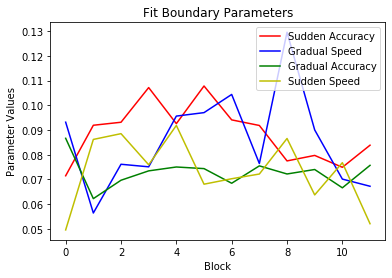

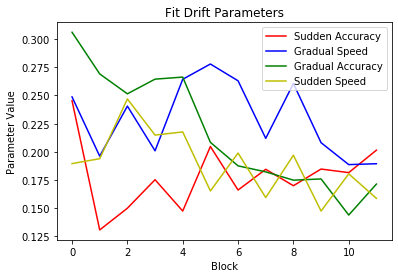

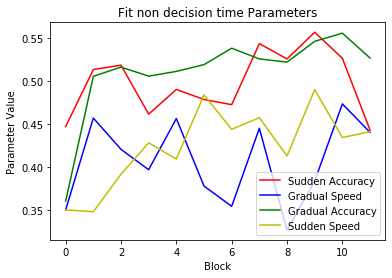

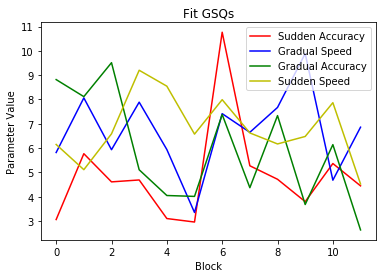

In [19]:
plot_all(fit_a, fit_v, fit_ter, fit_gsq, optim_fail)

# Wald Simulator

In [ ]:
def wald_sim(n_samples, par):
    #Diffusion Coefficient
    dc = 0.1  
    #timesteps for randomwalk
    ts = 0.001
    #Unpack Parameters
    a = par[0]
    v = par[1]
    ter = par[2]
    #Average change in position of evidence accumulation
    dav = v*ts
    #standard deviation in position changes
    dsd = np.sqrt(ts*(dc)**2)
    rt = np.zeros(n_samples)
    for i in range(n_samples):
        out = 0
        pos = 0 #Position of vidence acc. process
        count = 0 #counter for timesteps
        while(out == 0):
            pos = pos + np.random.normal(dav, dsd, 1)
            count = count + 1
            if pos > a:
                out = 1
        rt[i] = count * ts
    rt = rt + ter
    return rt


In [ ]:
def get_sim_quantiles(n_samples, par):
    return np.quantile(wald_sim(n_samples, par), [0.1, 0.3, 0.5, 0.7, 0.9])

In [ ]:
sim_quantiles = np.zeros((59, 12, 5))
data_quantiles = np.zeros((59, 12, 5))
total_times = its + initiation_times
for participant in range(1, 59):
    if participant == 7:
        continue
    for block in range(12):
        data_to_quantile = total_times[participant, block]
        #data_to_quantile = data_to_quantile[data_to_quantile < 8]
        #data_to_quantile = data_to_quantile[data_to_quantile > 0.0004]
        sim_quantiles[participant, block, :] = get_sim_quantiles(100, [fit_a[participant, block], fit_v[participant, block], fit_ter[participant, block]])
        data_quantiles[participant, block, :] = np.quantile(data_to_quantile, [0.1, 0.3, 0.5, 0.7, 0.9])
        

In [ ]:
def plot_quantile_comparisons(condition, block):
    data_quantile_condition = np.concatenate((data_quantiles[condition+1:7:4], data_quantiles[condition+8::4]))
    sim_quantile_condition = np.concatenate((sim_quantiles[condition+1:7:4], sim_quantiles[condition+8::4]))    
    #tb2_plot, axes = plt.subplot(2, 2)
    if condition == 0:
        condition_text = "Sudden Accuracy"
    if condition == 1:
        condition_text = "Gradual Speed"
    if condition == 2:
        condition_text = "Gradual Accuracy"
    if condition == 3:
        condition_text = "Sudden Speed"
    textstr = ''.join(["Block: ", str(block), "\nCondition: ", condition_text ])
    error_sim = stat.sem(sim_quantile_condition, axis = 0)[block]
    plot_sim = plt.errorbar(range(5), np.mean(sim_quantile_condition, axis = 0)[block], error_sim, linestyle = 'None', marker = 's', capsize=3)
    error_data = stat.sem(data_quantile_condition, axis = 0)
    plot_data = plt.errorbar(range(5), np.mean(data_quantile_condition, axis = 0)[block], error_sim, color = 'r', linestyle = 'None', marker = 's', capsize=3)
    plt.legend((plot_sim, plot_data), ('Simulated', 'Actual'))
    plt.text(1, 1.6, textstr)
    plt.xlabel('Quantiles')
    plt.ylabel('Response Times')
    plt.ylim(0, 2)
    plt.show()

In [ ]:
interact(plot_quantile_comparisons, condition = widgets.ToggleButtons(options = range(4)), block = widgets.IntSlider(max = 11, min = 0, value = 0, step = 1))

# Plot Bar plots

In [ ]:
def plot_bar(total_times, block):
    data_medians = np.zeros(4)
    data_sems = np.zeros(4)
    for condition in range(4):
        #print (np.nanmean(np.nanmean(np.concatenate((total_times[condition+1:7:4], total_times[condition+8::4])), axis = 0), axis = 1)[block])
        data_medians[condition] = np.nanmean(np.nanmedian(np.concatenate((total_times[condition+1:7:4], total_times[condition+8::4])), axis = 0), axis = 1)[block]
        data_sems[condition] = stat.sem(np.nanmedian(np.concatenate((total_times[condition+1:7:4], total_times[condition+8::4])), axis = 0), axis = 1)[block]
        
    xpos = [0, 1, 3, 4]
    plt.bar(xpos, [data_medians[0], data_medians[3], data_medians[1], data_medians[2]], yerr= data_sems, capsize = 3)
    plt.xticks([0, 1, 2, 3, 4], ['Sudden Accuracy', 'Sudden Speed','', 'Gradual Speed', 'Gradual Accuracy'], rotation = 'vertical')

In [ ]:
plot_bar(total_time, 1)

In [18]:
#total_times = its
def get_quantile(total_times):
    quantiles = np.zeros((len(total_times), 12, 5))
    for participant in range(1, len(total_times)):
        if participant == 7:
            continue
        else:
            for block in range(12):
                quantiles[participant, block, :] =  np.quantile(total_times[participant, block], np.array([0.1, 0.3, 0.5, 0.7, 0.9]))
    
    return quantiles


In [ ]:
total_times
quantiles = get_quantile(total_times)


In [ ]:
fig, ax = plt.subplots(2, 2, sharex = True, sharey = True)
ax[0, 1].errorbar(range(1, 11), np.mean(quantiles[1::4][:, :, 3], axis = 0)[1:11], yerr = stat.sem(quantiles[1::4][:, :, 3])[1:11], capsize=3)
ax[1, 1].errorbar(range(1, 11), np.mean(quantiles[3::4][:, :, 3], axis = 0)[1:11], yerr = stat.sem(quantiles[3::4][:, :, 3])[1:11], capsize=3)
ax[1, 0].errorbar(range(1, 11), np.mean(quantiles[2::4][:, :, 3], axis = 0)[1:11], yerr = stat.sem(quantiles[2::4][:, :, 3])[1:11], capsize=3)
ax[0, 0].errorbar(range(1, 11), np.mean(quantiles[4::4][:, :, 3], axis = 0)[1:11], yerr = stat.sem(quantiles[4::4][:, :, 3])[1:11], capsize=3)
ax[0, 0].set_title('Sudden Speed')
ax[0, 1].set_title('Sudden Accuracy')
ax[1, 0].set_title('Gradual Speed')
ax[1, 1].set_title('Gradual Accuracy')

fig.suptitle('Movement Times')

In [20]:
its, mts = get_times()

In [21]:
total_times = mts -  initiation_times

In [19]:
#plt.rcParams[('figure.figsize')] = [8, 6]

def plot_rt_medians(rt, path):
    
    quantiles = get_quantile(total_times)
    plt.errorbar(range(1, 11), np.mean(quantiles[3::4][:, :, 2], axis = 0)[1:-1], yerr = stat.sem(quantiles[3::4][:, :, 3])[1:-1], capsize=3)
    plt.errorbar(0, np.mean(quantiles[3::4][:, :, 2], axis = 0)[0], yerr = stat.sem(quantiles[3::4][:, :, 3])[0], capsize = 3,  fmt = 's')
    plt.errorbar(11, np.mean(quantiles[3::4][:, :, 2], axis = 0)[11], yerr = stat.sem(quantiles[3::4][:, :, 3])[11], capsize=3,  fmt = 's')
    plt.text(x=5, y = 1, s = '14 Participants')
    plt.ylabel('Time(in seconds)')
    plt.xlabel('Block')
    plt.title('Gradual Accuracy')
    y_lim_max = np.max(np.mean(quantiles, axis = 0))
    
    plt.ylim((0.2, y_lim_max))
#    print(max(np.mean(quantiles[3::4][:, :, 3], axis = 0)[1:-1]) + 0.7)
#    plt.savefig(path+'learning_GA.png', dpi = 600)
    plt.show()
    
    plt.errorbar(range(1, 11), np.mean(quantiles[2::4][:, :, 2], axis = 0)[1:-1], yerr = stat.sem(quantiles[2::4][:, :, 3])[1:-1], capsize=3)
    plt.errorbar(0, np.mean(quantiles[2::4][:, :, 2], axis = 0)[0], yerr = stat.sem(quantiles[2::4][:, :, 3])[0], capsize = 3, fmt = 's'  )
    plt.errorbar(11, np.mean(quantiles[2::4][:, :, 2], axis = 0)[11], yerr = stat.sem(quantiles[2::4][:, :, 3])[11], capsize=3, fmt = 's')
    plt.text(x=5, y = 1, s = '15 Participants')
    plt.title('Gradual Speed')
    plt.ylabel('Time(in seconds)')
    plt.xlabel('Block')
    plt.ylim(0.2, y_lim_max)
#    plt.savefig(path+'learning_GS.png', dpi = 600)
    plt.show()
    
    plt.errorbar(range(1, 11), np.mean(quantiles[1::4][:, :, 2], axis = 0)[1:-1], yerr = stat.sem(quantiles[1::4][:, :, 3])[1:-1], capsize=3)
    plt.errorbar(0, np.mean(quantiles[1::4][:, :, 2], axis = 0)[0], yerr = stat.sem(quantiles[1::4][:, :, 3])[0], capsize = 3,  fmt = 's')
    plt.errorbar(11, np.mean(quantiles[1::4][:, :, 2], axis = 0)[11], yerr = stat.sem(quantiles[1::4][:, :, 3])[11], capsize=3,  fmt = 's')
    plt.text(x=5, y = 1, s = '15 Participants')
    plt.title('Sudden Accuracy')
    plt.ylabel('Time(in seconds)')
    plt.xlabel('Block')
    plt.ylim(0.2, y_lim_max)
#    plt.savefig(path+'learning_SA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), np.mean(quantiles[4::4][:, :, 2], axis = 0)[1:-1], yerr = stat.sem(quantiles[4::4][:, :, 3])[1:-1], capsize=3)
    plt.errorbar(0, np.mean(quantiles[4::4][:, :, 2], axis = 0)[0], yerr = stat.sem(quantiles[4::4][:, :, 3])[0], capsize = 3,  fmt = 's')
    plt.errorbar(11, np.mean(quantiles[4::4][:, :, 2], axis = 0)[11], yerr = stat.sem(quantiles[4::4][:, :, 3])[11], capsize=3,  fmt = 's')
    plt.text(x=5, y = 1, s = '14 Participants')
    plt.title('Sudden Speed')
    plt.ylabel('Time(in seconds)')
    plt.xlabel('Block')
    plt.ylim(0.2, y_lim_max)
#    plt.savefig(path+'learning_SS.png', dpi = 600)
    plt.show()
    


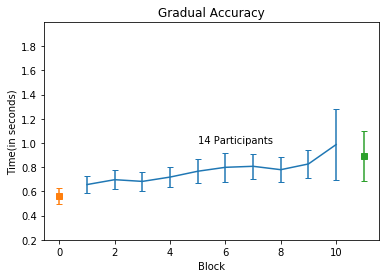

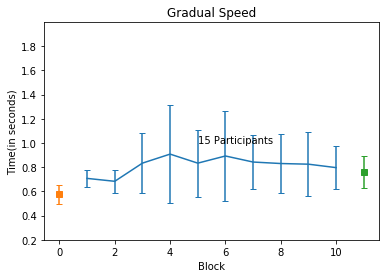

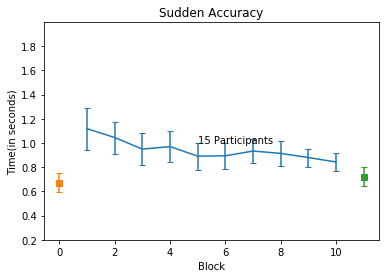

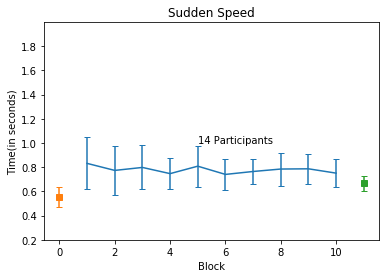

In [23]:
#plt.ylim
total_times = its + initiation_times
plot_rt_medians(total_times, "C:/Users/Tejas/OneDrive/Research/Conferences and Papers/Psychonomics 2019/Planning Times/")


In [24]:
def plot_rt_medians_transfer(total_times, text, path):
    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = np.array([np.mean(quantiles[1::4][:, :, 2], axis = 0)[11],
                  np.mean(quantiles[4::4][:, :, 2], axis = 0)[11],
                  np.mean(quantiles[3::4][:, :, 2], axis = 0)[11],
                  np.mean(quantiles[2::4][:, :, 2], axis = 0)[11]] 
                  )
    y_sem = np.array([stat.sem(quantiles[1::4][:, :, 2])[11], 
                    stat.sem(quantiles[4::4][:, :, 2])[11],
                    stat.sem(quantiles[3::4][:, :, 2])[11],
                    stat.sem(quantiles[2::4][:, :, 2])[11]])
    #print (y_sem[0])
    plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, color = 'Blue', alpha = 1)
    plt.bar(2, y[1], yerr = y_sem[1], capsize = 3, color = 'Blue', alpha = 0.5)
    plt.bar(1, y[2], yerr = y_sem[2], capsize = 3, color = 'Green', alpha = 1)
    plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, color = 'Green', alpha = 0.5)

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 2, 1, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('Time')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.title(text)
    #plt.tight_layout()
    #plt.savefig(path+'transfer.png', dpi = 300)

    

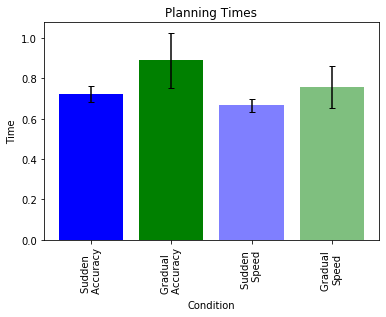

In [28]:
total_times = its + initiation_times
plot_rt_medians_transfer(total_times, 'Planning Times', "C:/Users/Tejas/OneDrive/Research/Conferences and Papers/Psychonomics 2019/Planning Times/")

In [31]:
total_times = mts - initiation_times


In [ ]:
plt.hist(np.ravel(total_times[3::4][:, -1, :]), bins = 100)

In [ ]:
y_test = np.mean(np.median(total_times[3::4], axis = 2)[:, -1])
y_test_sem = stat.sem(np.median(total_times[3::4], axis = 2)[:, -1])

plt.bar(0, y_test, yerr = y_test_sem)

In [ ]:
quantiles = get_quantile(total_times)


In [ ]:
np.mean(quantiles[3::4][:, :, 2], axis = 0)[-1]